# Lab 9b: Profit Diagrams of Composite Contracts at Expiration
Call and put contracts can be combined to develop composite contract structures with interesting payoff diagrams. Let's limit our focus to contracts that have the same underlying asset and the same expiration date. A composite option contract be composed of $d$ legs (individual contracts) in the contract set $\mathcal{C}$ where each leg $i\in\mathcal{C}$ is written with respect to the same underlying stock `XYZ` and has the same expiration date. Then, the overall payoff of the composite contract $\hat{V}(S(T),K_{1},\dots,K_{d})$ is given by:


$$\hat{V}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}V_{i}(S(T),K_{i})$$


where $K_{i}$ denotes the strike price of contract $i\in\mathcal{C}$. The overall profit of the composite contract $\hat{P}$ is given by:


$$\hat{P}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}P_{i}(S(T),K_{i})$$


where $\theta_{i}$ denotes the direction of contract $i$: if contract $i$ is short (sold), then $\theta_{i}=-1$, otherwise $\theta_{i}=1$, $n_{i}$ denotes the copy number of contract $i$, ${V}_{i}(S(T),K_{i})$ denotes the payoff of contract $i$, and $P_{i}(S(T),K_{i})$ denotes the profit of contract $i$. Finally, the profit for contract of type $\star$ is given by:

$$P_{\star}(K,S(T)) = {V}_{\star}(K,S(T)) -  \mathcal{P}_{\star}(K,S(0))$$

where $\mathcal{P}_{\star}(K,S(0))$ denotes the premium of contract $\star$, and ${V}_{\star}(K,S(T))$ denotes the payoff of contract $\star$ at expiration.


## Learning Objectives
`Lab 9b` will familiarize students with computing the profit diagrams for some common composite contracts at expiration. To support this objective, we will:

* __Task 1__ (duration 15 min): Explore the options chain data (premium value versus as a function of strike price) for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart. com](https://www.barchart.com) for contracts with 31 days to expiration, i.e., `31-DTE`. For `Lab 9b`, the share price of `AMD` is `S(0) = 117.50 USD/share`, and the average implied volatility for `AMD` options with `31-DTE` is `IV = 51.75%`. The premium values, given these parameters, are given in the data.
    * `TODO`: Why does a `near the money` contract have a non-zero premium?
    * `TODO`: Why does the premium curve have the observed shape as a function of the strike price?
    * `TODO` Keep in mind that this figure reflects premium values at 31 DTE. How do you think this figure changes as DTE approaches zero?
* __Task 2__ (duration 35 min): Demonstrate the computation and visualization of the profit diagram for a `short straddle` on `AMD`
    * `TODO`: What is the directional assumption of a `short straddle`?
    * `TODO`: What is the business case for a `short straddle`?
    * `TODO`: What is the maximum loss for the `short straddle` demonstrated above? Under which circumstances would this occur?

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Labs-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/v

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the excercises:

The `MyAmericanPutContractModel` and `MyAmericanCallContractModel` types encode information about American `put` and `call` contracts:
* The field `K::Float64` is the strike price of the `put` (or `call`) contract
* The field `sense::Union{Nothing, Int64}` encodes if the contract was sold (`sense = -1` short) or purchased (`sense = 1` long). 
* The `DTE::Union{Nothing, Float64}` field encodes the number of days to expiration (DTE) of the contract
* The `IV::Union{Nothing, Float64}` field encodes the implied volatility, i.e., the share price volatility of the underlying asset for this `put` or `call` contract
* The `premium::Union{Nothing, Float64}` field is the cost of the contract (what we'll be calculating in this example)
* The `ticker::Union{Nothing, String}` field encodes the symbol for a `put` or `call` contract, see [How to Read a Stock Options Ticker](https://polygon.io/blog/how-to-read-a-stock-options-ticker/).
* The `copy::Union{Nothing, Int64}`  field holds the number of copies purchased or sold

### Functions

`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`build(model::Type{MyAmericanPutContractModel}, data::NamedTuple) -> MyEuropeanPutContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAmericanPutContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyAmericanCallContractModel}, data::NamedTuple) -> MyEuropeanCallContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAmericanCallContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`profit(contracts::Array{T,1}, S::Array{Float64,1}) -> Array{Float64,2} where T <: AbstractContractModel`. The `profit(...)` function takes an array of contract models and an array of share prices at expiration and returns an array of profit values for each contract.  Each row of the array holds a particular future share price at expiration, while each column holds the profit value for a particular contract (in the same order as the `contracts` array). The last column is the aggregate profit

### Constants

In [2]:
Sₒ = 117.50; # initial share price
number_of_steps = 1001;
β₁ = 0.70;
β₂ = 1.30;
β = range(β₁, stop = β₂, length = number_of_steps) |> collect;

## Task 1: Load `AMD` options chain dataset
To start, load the options data using using the `MyOptionsChainDataSet(...)` function and store the data in the `options_dataset` variable:

In [15]:
options_dataset = MyOptionsChainDataSet()

Row,Strike,Bid,Midpoint,Ask,Last,AVGIV,IV,Type
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,String7
1,35,82.45,83.03,83.6,79.5,0.5175,2.3033,Call
2,40,77.5,77.95,78.4,48.5,0.5175,1.8801,Call
3,45,72.85,73.15,73.45,69.9,0.5175,1.2223,Call
4,50,67.85,68.13,68.4,71.0,0.5175,1.4811,Call
5,55,62.85,63.18,63.5,61.08,0.5175,0.8203,Call
6,60,57.9,58.18,58.45,57.1,0.5175,1.1983,Call
7,65,52.95,53.25,53.55,52.66,0.5175,0.8171,Call
8,70,47.9,48.25,48.6,46.79,0.5175,0.6489,Call
9,75,43.05,43.33,43.6,43.01,0.5175,0.6885,Call


### Visualize
Before we compute the profit of the composite contract in __Task 2__, let's look at how the premium of `31-DTE` call and put contracts for `AMD` changes with the strike price `K`. Set a lower $K_{1}$ and an upper $K_{2}$ value for the strike price in the `K₁` and `K₂` variables:

In [4]:
K₁ = 60.0;
K₂ = 160.0;

Next, build an array of strike prices between a lower $K_{1}$ and upper $K_{2}$ strike price, and store this value in the `K_array`:

In [5]:
K_array = range(K₁, stop=K₂, length = number_of_steps) |> collect;

Now that we have the `K_array`, we can filter the `options_dataset` for call and put contracts with these strike prices using the `filter(...)` command exported by the [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl) package. The `filter(...)` command returns the rows in `options_dataset` that match the search criteria as a `DataFrame`. We'll save the put data in the `put_dataset` variable and the call data in the `call_dataset` variable:

In [6]:
put_dataset = filter([:Type, :Strike] => (x,y)-> x == "Put" && y ∈ K_array, options_dataset);
call_dataset = filter([:Type, :Strike] => (x,y)-> x == "Call" && y ∈ K_array, options_dataset);

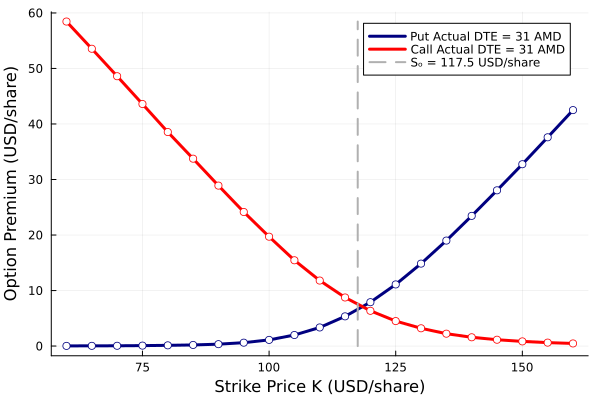

In [7]:
plot(put_dataset[:,:Strike], put_dataset[:,:Ask],label="Put Actual DTE = 31 AMD", lw=3, c=:navyblue)
plot!(call_dataset[:,:Strike], call_dataset[:,:Ask],label="Call Actual DTE = 31 AMD", lw=3, c=:red)
scatter!(call_dataset[:,:Strike], call_dataset[:,:Ask],label="", mc=:white, msc=:red)
scatter!(put_dataset[:,:Strike], put_dataset[:,:Ask],label="", mc=:white, msc=:navyblue)

VLINE = zeros(number_of_steps, 2)
VLINE[:,1] .= Sₒ*ones(number_of_steps)
VLINE[:,2] .= range(0.0, stop = maximum(call_dataset[:,:Ask]), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Premium (USD/share)", fontsize=18) 

### Discussion questions
1. `TODO` Why does a `near the money` contract have a non-zero premium?
2. `TODO` Why does the premium curve have the observed shape as a function of the strike price?
3. `TODO` Keep in mind that this figure reflects premium values at 31 DTE. How do you think this figure changes as DTE approaches zero?

## Task 2: Compute the Profit diagram for a `AMD` short straddle with `31-DTE`

A [straddle](https://www.investopedia.com/terms/s/straddle.asp) is a _neutral strategy_ constructed by simultaneously buying (or selling) a put and a call option on the same underlying asset `XYZ`, with the _same expiration_, and the _same strike price_. Depending upon the choice of the strike prices and whether an investor buys or sells both legs, a [straddle](https://www.investopedia.com/terms/s/straddle.asp) can be initiated as a credit or debit and can potentially have undefined profit or loss.

Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the price of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the `put` contract, $j=2$ denote the `call` contract; for a straddle $K_{1}= K_{2}\equiv{K}$ (both legs have the same strike). The profit for a single straddle contract $\hat{P}$ at expiration is given by:

$$\hat{P} = \theta\cdot\left(P_{1}+P_{2}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a `put` and a `call` contract, the overall profit $\hat{P}$ is given by:

$$\hat{P} = \theta\cdot\Bigl[(K-S)^{+}+(S-K)^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p} = (K-S)^{+}=\max(K-S,0)$ is the payoff function for the `put` contract, and $V_{c} = (S-K)^{+} = \max(S-K,0)$ is the payoff function for the `call` contract. The profit (or loss) of a straddle has three regimes given by:

$$
\hat{P} = \begin{cases}
  \theta\cdot\Bigl[(S-K)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S>K \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & S=K \\
    \theta\cdot\Bigl[(K-S)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S<K
\end{cases}
$$

Finally, a straddle has _two_ possible breakeven points denoted as $S^{+}$ and $S^{-}$:
* If $S>K$: a straddle will breakeven at $S^{+} = K + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$
* If $S<K$: a straddle will breakeven at $S^{-} = K - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$.

#### Short straddle
For a short straddle, we sell (are short) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a short straddle with the parameters:

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = `K` USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `short call` leg is given by $K_{2}$ = `K` USD/share with `DTE = 31 days`

Set the strike price `K` of the short `call` and `put` legs:

In [8]:
K = 120.0; 

Next, let's use the `build(...)` method to construct instances of the `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models, which we'll use to model the contracts. 
* Look up the premium for contracts with strike price `K` from the `options_dataset` for each of these contracts using the `filter(...)` command exported by the [DataFrames.jl](https://dataframes.juliadata.org/stable/) package. Use the `Midpoint` price as an estimate of the premium paid for the contract.

In [9]:
premium_put_straddle = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Midpoint];
premium_call_straddle = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Midpoint];

Now, we can construct the contract models using the `build(...)` method. To do the profit diagram calculation at expiration, we need to pass in a few pieces of information into the `build(...)` method:

* The profit diagram calculation requires that we pass the strike price `K`, the `premium` value, the `sense`, and the number of contracts in the `copy` parameter into the `build(...)` method for each contract model

In [10]:
straddle_put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_put_straddle, sense = -1, copy = 1
));

staddle_call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_call_straddle, sense = -1, copy = 1
));

Next, we construct an array of share prices for `AMD` at expiration and store this in the `share_price_array` variable. I'm `flexing`  by using a short-cut syntax called an [Array comprehension](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) to populate the `share_price_array` array in a single line:

In [11]:
share_price_array = [Sₒ*β[i] for i ∈ eachindex(β)];

Finally, we can compute the `profit` for the `AMD` short straddle by calling the `profit(...)` function. 
* Pass in an array of contract models as the first argument and the `share_price_array` as the second argument to the `profit(…)` function. The `profit(…)` function returns an array holding the share price at expiration in `col 1`, the P/L for each leg in `col 2 ... col C`, and the overall P/L in the last column. Each row corresponds to a different share price at expiration.

Let's store the output from the `profit(...)` function in the `profit_array` variable:

In [12]:
profit_array = profit([straddle_put_contract_model, staddle_call_contract_model], share_price_array);

### Visualize

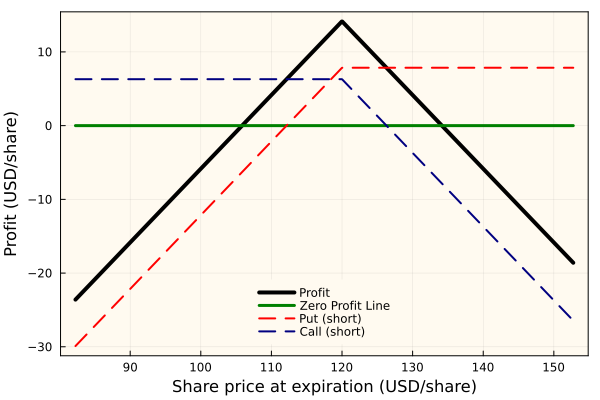

In [13]:
plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black,
        bg="floralwhite", background_color_outside="white", framestyle = :box, fg_legend = :transparent,
        legend=:bottom)

number_of_steps = length(profit_array[:,1]);
BEL = zeros(number_of_steps)
plot!(profit_array[:,1], BEL,lw=3, c=:green, label="Zero Profit Line")
plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call (short)", ls=:dash, c=:navyblue)

xlabel!("Share price at expiration (USD/share)", fontsize=18)
ylabel!("Profit (USD/share)", fontsize=18)

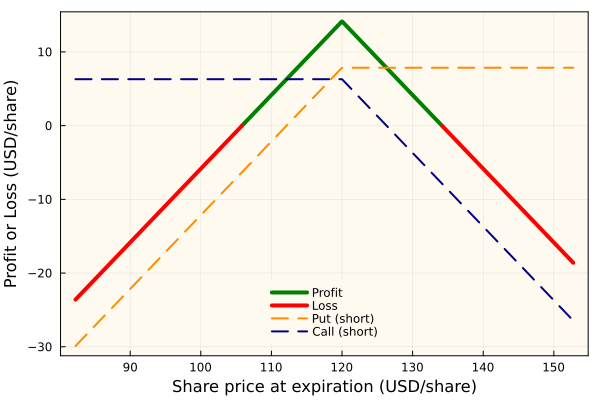

In [14]:
profit_idx = findall(>(0), profit_array[:,4])
loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
plot(profit_array[profit_idx,1], profit_array[profit_idx,4], lw=4, label="Profit", c=:green,
        bg="floralwhite", background_color_outside="white", framestyle = :box, fg_legend = :transparent,
        legend=:bottom)
plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:darkorange)
plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call (short)", ls=:dash, c=:navyblue)
xlabel!("Share price at expiration (USD/share)", fontsize=18)
ylabel!("Profit or Loss (USD/share)", fontsize=18)

### Discussion questions
* `TODO`: What is the directional assumption of a `short straddle`?
* `TODO`: What is the business case for a `short straddle` (i.e., when would you use this strategy--what do you anticipate happening to the share price)?
* `TODO`: What is the maximum loss for the `short straddle` demonstrated above? Under which circumstances would this occur?